In [11]:
import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal
import os
tavily = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

In [12]:
SELF_CONSISTENCY_PROMPT  = """You are a research assistant conducting research on the user's query. For context, today's date is {date}.


Available Tools:
1. **tavily_search** – For conducting web searches to gather information.
2. **think_tool** – For reflection, evaluation, and strategic planning during research.
**CRITICAL:** Use think_tool after each search to expand reasoning paths and evaluate insights.

Instructions:
1. Think step by step and explain your reasoning clearly for each solution path.
2. After each reasoning chain, provide a clear final answer as "Answer: <your_answer>".
3. Generate **multiple independent reasoning chains** (at least 3–5), exploring different approaches to the problem.
   - Each chain can use the tools to gather or validate information.
   - Example reasoning directions: definition-focused, application-focused, technology-focused, pros/cons, historical context, etc.
4. After generating all chains, compare them and select the **most consistent answer** across the chains. Mark it as the **Final Answer**.

Reasoning Chain 1:
- Step 1: [Optionally call tavily_search or think_tool here to gather information or evaluate paths]
- Step 2:
...
Answer:  

Reasoning Chain 2:
- Step 1: [Optionally call tavily_search or think_tool here]
- Step 2:
...
Answer:  

Reasoning Chain 3:
- Step 1: [Optionally call tavily_search or think_tool here]
- Step 2:
...
Answer:  

Reasoning Chain 4 (optional):
...
Answer:  

Reasoning Chain 5 (optional):
...
Answer:  

Final Answer (after evaluating all chains for consistency):  
Answer:  

Notes for the model:
- Each reasoning chain should be **independent** and explore different perspectives.
- Use the tools strategically to **expand, verify, or reflect** on your reasoning.
- Include key examples, sources, or insights when relevant.
- The Final Answer should summarize the consensus or strongest reasoning path.
"""

In [13]:
@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

In [14]:

# DEMO TOOL DEFINITIONS



@tool
def tavily_search(query: str) -> str:
    """
    Search the web for real-time information using Tavily API.
 
    Input:
        query (str): A search query string describing the information you want.
                     Example: "latest AI news in 2025"
 
    Output:
        str: A formatted string containing up to 3 search results with titles and URLs.
             Example:
                 - OpenAI releases GPT-5: https://example.com/openai-news
                 - Advances in AI Agents: https://example.com/ai-agents
                 - Future of Generative AI: https://example.com/genai-future
    """
    try:
        results = tavily.search(query, max_results=3)  # returns dict with 'results'
        contents = [r.get("content", "").strip() for r in results.get("results", []) if r.get("content")]
        
        if not contents:
            return "No relevant content found."
        
        # Join all content into one paragraph
        paragraph = " ".join(contents)
        
        # Optional: shorten to first 400 characters for brevity
        if len(paragraph) > 400:
            paragraph = paragraph[:400].rsplit('.', 1)[0] + '.'
        
        return paragraph

    except Exception as e:
        return f"Error during Tavily search: {e}"


@tool
def think_tool(reflection: str) -> str:
    """
    Record strategic reflections during the research process.

    Args:
        reflection (str): Detailed reasoning or assessment of current findings, 
                          gaps, or next steps.

    Returns:
        str: Confirmation message that the reflection was recorded.
    """
    return f"Reflection recorded: {reflection}"


@tool
def summarize_tool(text: str) -> str:
    """
    Summarize raw research text into concise insights.

    Args:
        text (str): The raw research text or search results.

    Returns:
        str: A summarized version of the input text.
    """
    return (
        "Summary: In 2024, AI is streamlining healthcare operations, improving diagnostics, "
        "and enabling predictive care models to enhance outcomes."
    )


@tool
def citation_tool(sources: list[str]) -> str:
    """
    Format and return a clean, structured list of citations.

    Args:
        sources (list[str]): A list of source references or URLs.

    Returns:
        str: A formatted string with citations listed one per line.
    """
    return (
        "- Source: World Health Organization (WHO) AI in Healthcare Report, 2024\n"
        "- Source: Journal of Medical Internet Research, Vol. 26, 2024\n"
        "- Source: Deloitte Insights – AI in Healthcare, 2024"
    )


@tool
def sentiment_tool(text: str) -> str:
    """
    Analyze the sentiment of the given research text.

    Args:
        text (str): The text or summary to analyze.

    Returns:
        str: A placeholder sentiment analysis result.
    """
    return (
        "Sentiment Analysis: Overall positive. The outlook on AI in healthcare is "
        "optimistic, with emphasis on efficiency and patient outcomes."
    )

# ==========================
# DEMO LLM BIND
# ==========================


from langchain_core.tools import Tool


tools = [
    Tool(
        name="tavily_search", 
        func=tavily_search, 
        description="Perform web searches to gather research information."
    ),
    Tool(
        name="think_tool", 
        func=think_tool, 
        description="Reflect on findings and plan the next research step."
    )
    # ,
    # Tool(
    #     name="summarize_tool", 
    #     func=summarize_tool, 
    #     description="Summarize long texts or raw search results into concise notes."
    # ),
    # Tool(
    #     name="citation_tool", 
    #     func=citation_tool, 
    #     description="Format a clean list of citations or sources for references."
    # ),
    # Tool(
    #     name="sentiment_tool", 
    #     func=sentiment_tool, 
    #     description="Analyze sentiment in research findings (positive, negative, neutral)."
    # ),
]




In [15]:

from langchain_core.tools import tool

from langchain import hub
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(model = 'gpt-4o-mini',temperature=0.7,api_key=os.getenv('open_ai'))


In [16]:
llm_with_tools = llm.bind_tools(tools)

In [17]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System
# Node
def assistant(state: MessagesState):
   # print('entire chat')
   # for m in state['messages']:
   #    m.pretty_print()
   return {"messages": [llm_with_tools.invoke([SELF_CONSISTENCY_PROMPT] + state["messages"])]}

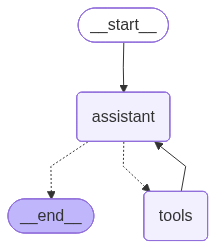

In [18]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [19]:
messages = [HumanMessage(content="explain me requirements for tracking in amazon jungle")]
# messages = [HumanMessage(content="what is ai")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

explain me requirements for tracking in amazon jungle
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_QiBJZlTAwEJgMd89Zfpo7m5O)
 Call ID: call_QiBJZlTAwEJgMd89Zfpo7m5O
  Args:
    __arg1: requirements for tracking in Amazon jungle
================================= Tool Message =================================
Name: tavily_search

# Jungle and canopy nature walks in the Amazon ### Guided walks in the Peruvian Amazon #### Explore the Amazon rainforest on foot: hiking the jungle floor and canopies. At a height of more than 25 m (85 ft) and a length of more than 500 m (1,580 ft), a guided canopy nature walk boasts exceptional views of the intriguing Amazon Rainforest.
================================== Ai Message ==================================
Tool Calls:
  think_tool (call_dE2JbCHhN6OTIcwTNvT75JcW)
 Call ID: call_dE2JbCHhN6OTIcwTNvT75JcW